In [3]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
from collections import Counter
import seaborn as sns

In [4]:
maps = {"Strongly disagree":1,"Disagree":2,"Somewhat disagree":3,
        "Neither disagree nor agree":4,"Somewhat agree":5,"Agree":6,
        "Strongly Agree":7}
model_mapping = {"Program Alpha is definitely better.":1,
                 "Program Alpha is probably better.":2,
                 "Program Alpha might be better.":3,
                 "I cannot decide.":4,
                 "Program Beta might be better.":5,
                 "Program Beta is probably better.":6,
                 "Program Beta is definitely  better.":7}
# set(df.model1_diversity_1)

loading data from Prolific CSV

In [8]:
df = pd.read_csv("./data/qualtrics/Topic_Model_Assessment_December+19,+2024_22.48.csv")

removing unnacceptable responses

In [9]:
df = df[df.mars == 'Never']
print(f"Number of tasks: {len(df)}")

Number of tasks: 84


number of comparisions

In [10]:
print(Counter(['-'.join(sorted([i,j])) for i,j in zip(df.Model1,df.Model2)]))
models_appearance = dict(Counter([i for i in list(df.Model1)+list(df.Model2)]))
print(models_appearance)
# list(df.columns)

Counter({'scholar-stm': 14, 'bertopic-lda': 14, 'lda-scholar': 14, 'bertopic-scholar': 14, 'lda-stm': 14, 'bertopic-stm': 14})
{'scholar': 42, 'bertopic': 42, 'lda': 42, 'stm': 42}


models quality (individual analysis)

In [11]:
# indv_ratings = pd.DataFrame(columns=["model","item","quality"])
ls = []

for _,row in df.iterrows():
    ls.append({"model":row.Model1,"item":"diversity","value":maps[row.model1_diversity_1]})
    ls.append({"model":row.Model1,"item":"distinct","value":maps[row.m1_distinct_1]})
    ls.append({"model":row.Model1,"item":"understand","value":maps[row.m1_understand_1]})

    ls.append({"model":row.Model2,"item":"diversity","value":maps[row.m2_diverse_1]})
    ls.append({"model":row.Model2,"item":"distinct","value":maps[row.m2_distinct_1]})
    ls.append({"model":row.Model2,"item":"understand","value":maps[row.m2_understand_1]})

indv_df = pd.DataFrame(ls)

<Axes: xlabel='item', ylabel='value'>

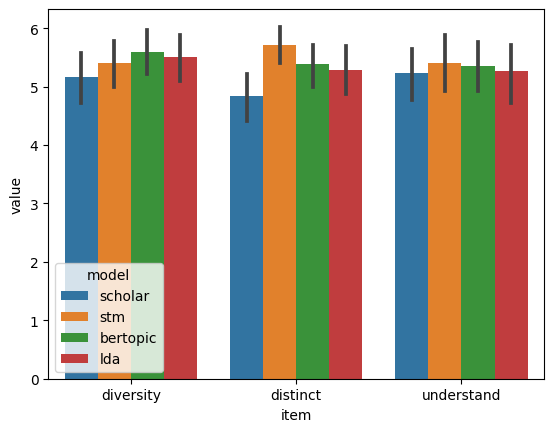

In [12]:
# sns.barplot(indv_df.groupby(["model","item"]).mean().reset_index(),
#             x="item",y="value",hue="model")
sns.barplot(indv_df,
            x="item",y="value",hue="model")

wins ratio

In [13]:
# models_appearance
models_win = {k:0 for k,v in models_appearance.items()}

for _,row in df.iterrows():
    if "Alpha" in row.model_selection_1:
        models_win[row.Model1] += 1
    else:
        models_win[row.Model2] += 1

models_ratio = {k:models_win[k]/models_appearance[k] for k in models_win.keys()}

print(models_win)
print(models_ratio)

{'scholar': 22, 'bertopic': 22, 'lda': 18, 'stm': 22}
{'scholar': 0.5238095238095238, 'bertopic': 0.5238095238095238, 'lda': 0.42857142857142855, 'stm': 0.5238095238095238}


how many times first model (i.e., Alpha model) wins 

In [14]:
count =0
alpha_wins = 0
for _,row in df.iterrows():
    if "Alpha" in row.model_selection_1:
        alpha_wins +=1
    count+=1

print(f"Alpha wins {100*alpha_wins/count:0.2f}%")

Alpha wins 42.86%


Anova on model_selection

In [15]:
#data prepartion
selection = []

for _,row in df.iterrows():
    compare_name = "-".join(sorted([row.Model1,row.Model2]))
    models = sorted([row.Model1,row.Model2])
    indv_rating = [(maps[row.model1_diversity_1],maps[row.m1_distinct_1],maps[row.m1_understand_1]),
                   (maps[row.m2_diverse_1],maps[row.m2_distinct_1],maps[row.m2_understand_1])]
    if row.Model2 == models[0]:
        indv_rating = [indv_rating[1],indv_rating[1]]
    compare_val = model_mapping[row["model_selection_1"]]
    selection.append({"comparison":compare_name,"model1":models[0],"model2":models[1],
                     "rating":compare_val if ("-".join([row.Model1,row.Model2]) == compare_name) 
                      else 8-compare_val,
                     "diverse1":indv_rating[0][0],"distinct1":indv_rating[0][1],"understand1":indv_rating[0][2],
                     "diverse2":indv_rating[1][0],"distinct2":indv_rating[1][1],"understand2":indv_rating[1][2]})

selection_df = pd.DataFrame(selection)
selection_df.head()

,comparison,model1,model2,rating,diverse1,distinct1,understand1,diverse2,distinct2,understand2
0,scholar-stm,scholar,stm,3,7,3,4,2,6,3
1,bertopic-lda,bertopic,lda,5,3,5,4,4,4,4
2,bertopic-lda,bertopic,lda,3,4,4,4,4,4,4
3,scholar-stm,scholar,stm,4,4,3,5,4,3,5
4,lda-scholar,lda,scholar,6,5,5,4,5,5,4


In [16]:
%%R -i selection_df
print(2)
# print(summary(analysis.variance <- aov(rating ~ (as.factor(model1)+as.factor(model2))^2,data=selection_df)))
print(summary(analysis.variance <- aov(rating ~ as.factor(comparison),data=selection_df)))
print(TukeyHSD(analysis.variance))

[1] 2
                      Df Sum Sq Mean Sq F value Pr(>F)
as.factor(comparison)  5  14.52   2.905   0.738  0.597
Residuals             78 307.14   3.938               
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = rating ~ as.factor(comparison), data = selection_df)

$`as.factor(comparison)`
                                     diff        lwr      upr     p adj
bertopic-scholar-bertopic-lda -0.42857143 -2.6199570 1.762814 0.9926062
bertopic-stm-bertopic-lda      0.78571429 -1.4056713 2.977100 0.9001291
lda-scholar-bertopic-lda       0.50000000 -1.6913856 2.691386 0.9850595
lda-stm-bertopic-lda           0.42857143 -1.7628142 2.619957 0.9926062
scholar-stm-bertopic-lda      -0.14285714 -2.3342427 2.048528 0.9999640
bertopic-stm-bertopic-scholar  1.21428571 -0.9770999 3.405671 0.5886886
lda-scholar-bertopic-scholar   0.92857143 -1.2628142 3.119957 0.8167787
lda-stm-bertopic-scholar       0.85714286 -1.3342427 3.048528 0.8618511
scholar

In [19]:
%%R -i selection_df
print(summary(analysis.variance <- aov(rating ~ (as.ordered(distinct1)*as.ordered(distinct2)+
                                              as.ordered(understand1)*as.ordered(understand2)+
                                              as.ordered(diverse1)*as.ordered(diverse2))
                                       ,data=selection_df)))
# print(TukeyHSD(analysis.variance))

                                                Df Sum Sq Mean Sq F value
as.ordered(distinct1)                            6  47.39   7.898   2.137
as.ordered(distinct2)                            5  41.65   8.330   2.254
as.ordered(understand1)                          6  22.72   3.786   1.025
as.ordered(understand2)                          6  30.80   5.134   1.389
as.ordered(diverse1)                             5   9.87   1.975   0.534
as.ordered(diverse2)                             5   3.83   0.765   0.207
as.ordered(distinct1):as.ordered(distinct2)      9  27.31   3.034   0.821
as.ordered(understand1):as.ordered(understand2)  4   4.24   1.060   0.287
as.ordered(diverse1):as.ordered(diverse2)        3   8.23   2.744   0.743
Residuals                                       34 125.63   3.695        
                                                Pr(>F)  
as.ordered(distinct1)                           0.0743 .
as.ordered(distinct2)                           0.0712 .
as.ordered(unde

In [20]:
%%R -i selection_df
print(summary(analysis.variance <- manova(cbind(diverse1,distinct1,understand1) ~ as.factor(model1)
                                       ,data=selection_df)))
print(summary(analysis.variance <- manova(cbind(diverse2,distinct2,understand2) ~ as.factor(model2)
                                       ,data=selection_df)))

print(summary(analysis.variance <- aov(distinct1 ~ as.factor(model1)
                                       ,data=selection_df)))

                  Df   Pillai approx F num Df den Df Pr(>F)
as.factor(model1)  2 0.042371  0.57718      6    160 0.7481
Residuals         81                                       
                  Df   Pillai approx F num Df den Df Pr(>F)
as.factor(model2)  2 0.074268   1.0284      6    160 0.4088
Residuals         81                                       
                  Df Sum Sq Mean Sq F value Pr(>F)
as.factor(model1)  2   4.73   2.363   1.355  0.264
Residuals         81 141.23   1.744               
